# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
# Extra requeriment: conda install pillow

data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

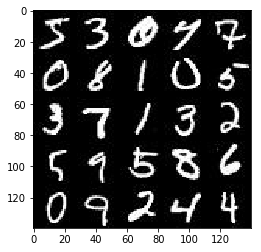

In [4]:
show_n_images = 25
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

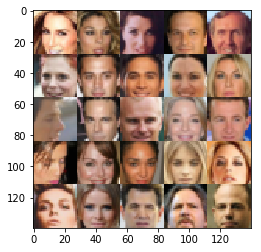

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=(), name="learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        # Xavier's Initialisation of weights will further improve the network
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.75):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    # We can smooth the real input labels to discriminator by multiplying them with 0.9.
    # This will improve performance of discriminatoR
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, print_every=10, show_every=100, figsize=(5,5)):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    images_count = data_shape[0]
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    input_real, input_z, learning_rate_tf = model_inputs(image_width=image_width,
                                                         image_height=image_height,
                                                         image_channels=image_channels,
                                                         z_dim=z_dim)
    d_loss, g_loss = model_loss(input_real=input_real,
                                input_z=input_z,
                                out_channel_dim=image_channels)
    d_opt, g_opt = model_opt(d_loss=d_loss, g_loss=g_loss,
                             learning_rate=learning_rate_tf, beta1=beta1)
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Scale image from (-0.5, 0.5) to (-1, 1)
                batch_images *= 2.0
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tf: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate})
                _ = sess.run(d_opt, feed_dict={
                        input_real: batch_images,
                        input_z: batch_z,
                        learning_rate_tf: learning_rate})
                
                _ = sess.run(g_opt, feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate})

                _ = sess.run(g_opt, feed_dict={
                        input_z: batch_z,
                        input_real: batch_images,
                        learning_rate_tf: learning_rate})
 
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z,
                                                input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess=sess,
                                          n_images=show_n_images,
                                          input_z=input_z,
                                          out_channel_dim=image_channels,
                                          image_mode=data_image_mode )
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.5187... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 1.3243
Epoch 1/2... Discriminator Loss: 1.3782... Generator Loss: 1.3202
Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 1.2847
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 1.3910
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.5403
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 1.7656
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.3862
Epoch 1/2... Discriminator Loss: 0.9665... Generator Loss: 1.2429
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.7526


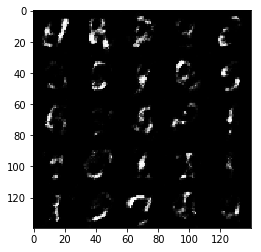

Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.3019
Epoch 1/2... Discriminator Loss: 1.0278... Generator Loss: 1.5283
Epoch 1/2... Discriminator Loss: 1.0587... Generator Loss: 1.0622
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.3192
Epoch 1/2... Discriminator Loss: 1.1367... Generator Loss: 1.4818
Epoch 1/2... Discriminator Loss: 1.3097... Generator Loss: 1.7188
Epoch 1/2... Discriminator Loss: 1.1147... Generator Loss: 1.4358
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.9982
Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 1.1226... Generator Loss: 1.3237


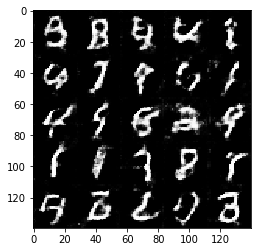

Epoch 1/2... Discriminator Loss: 1.1283... Generator Loss: 1.1583
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 1.0913
Epoch 1/2... Discriminator Loss: 1.1271... Generator Loss: 1.3183
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.9712
Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 1.0654
Epoch 1/2... Discriminator Loss: 1.1563... Generator Loss: 1.2754
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.2234
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 1.6493


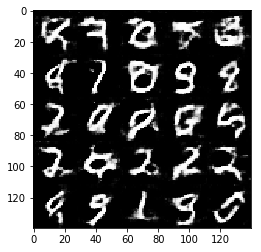

Epoch 1/2... Discriminator Loss: 1.1357... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 1.2347
Epoch 1/2... Discriminator Loss: 1.0920... Generator Loss: 1.1982
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 1.2585
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.2704
Epoch 1/2... Discriminator Loss: 1.1717... Generator Loss: 1.0906
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 1.1234
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 1.3732
Epoch 1/2... Discriminator Loss: 1.1263... Generator Loss: 1.4452
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 1.1563


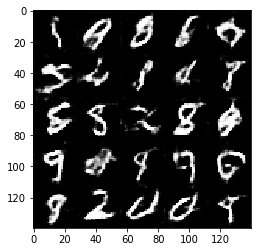

Epoch 1/2... Discriminator Loss: 1.0298... Generator Loss: 1.2878
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 1.6237
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 1.0375
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.2855
Epoch 1/2... Discriminator Loss: 0.9763... Generator Loss: 1.3458
Epoch 1/2... Discriminator Loss: 1.1047... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 1.1263... Generator Loss: 1.1954
Epoch 2/2... Discriminator Loss: 1.0774... Generator Loss: 1.5716
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 1.4462
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 1.2491


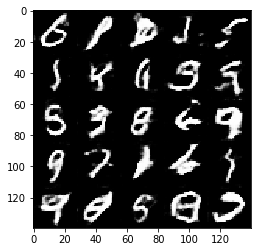

Epoch 2/2... Discriminator Loss: 0.9960... Generator Loss: 1.3751
Epoch 2/2... Discriminator Loss: 1.1299... Generator Loss: 1.2919
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 1.2332
Epoch 2/2... Discriminator Loss: 1.0214... Generator Loss: 1.4882
Epoch 2/2... Discriminator Loss: 1.0606... Generator Loss: 1.3612
Epoch 2/2... Discriminator Loss: 0.9484... Generator Loss: 1.4478
Epoch 2/2... Discriminator Loss: 1.0906... Generator Loss: 1.4408
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 1.0996
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 1.3692
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 1.2067


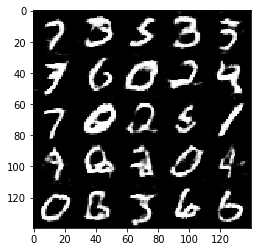

Epoch 2/2... Discriminator Loss: 1.1202... Generator Loss: 1.0884
Epoch 2/2... Discriminator Loss: 1.0754... Generator Loss: 1.5671
Epoch 2/2... Discriminator Loss: 1.0839... Generator Loss: 1.3223
Epoch 2/2... Discriminator Loss: 1.0928... Generator Loss: 1.6585
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 1.7374
Epoch 2/2... Discriminator Loss: 1.5691... Generator Loss: 2.3208
Epoch 2/2... Discriminator Loss: 1.0427... Generator Loss: 1.0691
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 1.3228
Epoch 2/2... Discriminator Loss: 1.0466... Generator Loss: 1.1851
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 1.5841


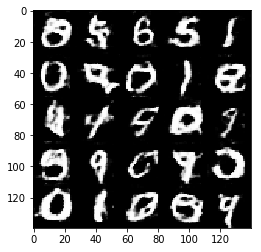

Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 0.9176
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.0236
Epoch 2/2... Discriminator Loss: 1.0150... Generator Loss: 1.2270
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 1.3439
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 1.6792
Epoch 2/2... Discriminator Loss: 0.9986... Generator Loss: 1.2654
Epoch 2/2... Discriminator Loss: 0.9351... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 1.0700... Generator Loss: 1.3998
Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 1.4046
Epoch 2/2... Discriminator Loss: 1.1117... Generator Loss: 1.3146


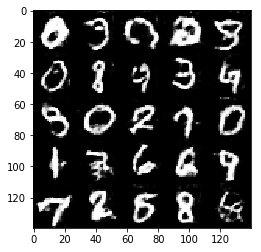

Epoch 2/2... Discriminator Loss: 1.0032... Generator Loss: 1.1733
Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.2263
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 1.8623
Epoch 2/2... Discriminator Loss: 1.1079... Generator Loss: 1.4594
Epoch 2/2... Discriminator Loss: 1.0752... Generator Loss: 1.5102
Epoch 2/2... Discriminator Loss: 1.0393... Generator Loss: 1.3444
Epoch 2/2... Discriminator Loss: 0.9655... Generator Loss: 1.0761
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 2.1075
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 1.4426


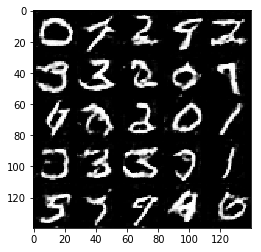

Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 1.2343
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.2623


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.00015
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.8666
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 2.5198
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 2.6614
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.5607
Epoch 1/1... Discriminator Loss: 0.5108... Generator Loss: 2.7418
Epoch 1/1... Discriminator Loss: 0.5220... Generator Loss: 2.1931
Epoch 1/1... Discriminator Loss: 0.6045... Generator Loss: 1.9809
Epoch 1/1... Discriminator Loss: 0.6633... Generator Loss: 1.6443
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 2.1295
Epoch 1/1... Discriminator Loss: 0.6435... Generator Loss: 1.9112


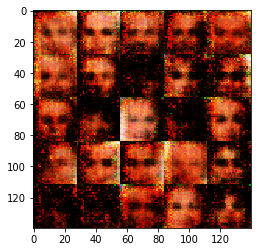

Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 1.7026
Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 3.1287
Epoch 1/1... Discriminator Loss: 0.8307... Generator Loss: 2.0680
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.2945
Epoch 1/1... Discriminator Loss: 0.7498... Generator Loss: 1.6043
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.8759
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.5881
Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 1.8021
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 1.1155... Generator Loss: 1.4756


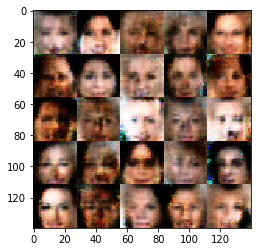

Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.8371
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6008
Epoch 1/1... Discriminator Loss: 1.1050... Generator Loss: 1.2712
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 1.2948
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 0.4740
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 1.1234
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7313


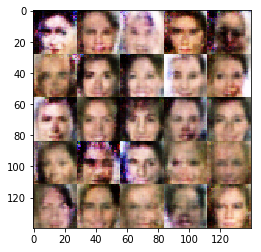

Epoch 1/1... Discriminator Loss: 1.4106... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 1.1099
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.5636... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.5681... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.8438


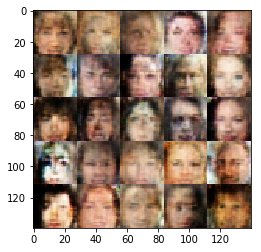

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.7714... Generator Loss: 0.5189
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.6374... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5652... Generator Loss: 0.7328


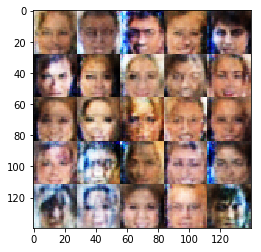

Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.4670... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.4639... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.8612


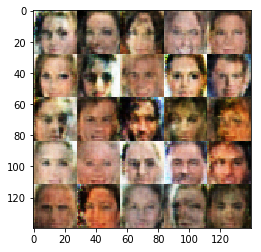

Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4786... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6913


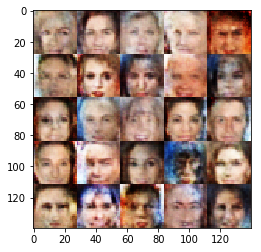

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9330
Epoch 1/1... Discriminator Loss: 1.5067... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.5395... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.5618... Generator Loss: 0.6277


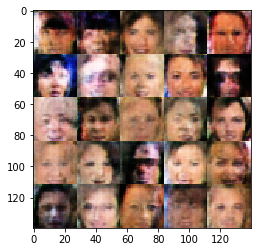

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.5523... Generator Loss: 0.6237
Epoch 1/1... Discriminator Loss: 1.5302... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.6437... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.6527... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.5744... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.6585


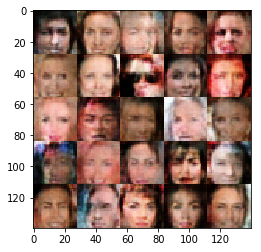

Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.6021... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7137


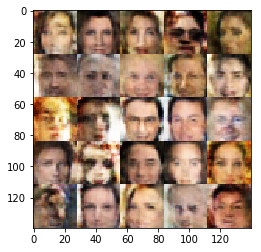

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.7323... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.5643


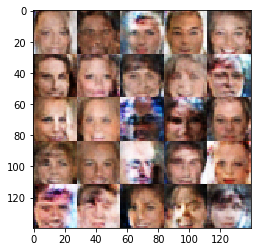

Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.5294... Generator Loss: 0.6425
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.5599... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.6535... Generator Loss: 0.6116


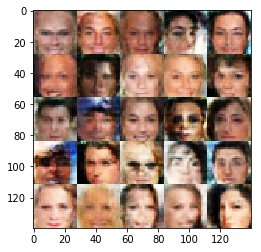

Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7967
Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.6342... Generator Loss: 0.8253


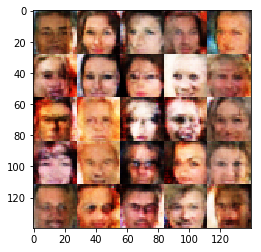

Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7756


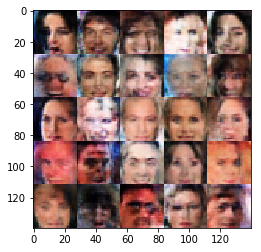

Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.6801
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.6020... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 1.3599... Generator Loss: 0.6422


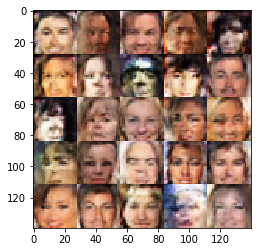

Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3118... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7758


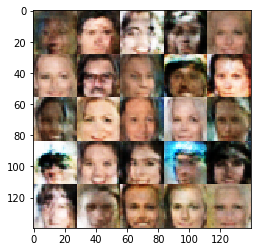

Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7308


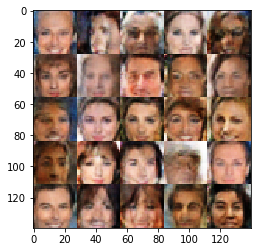

Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7705
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.6242


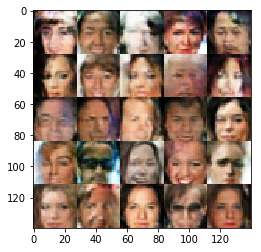

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.8431


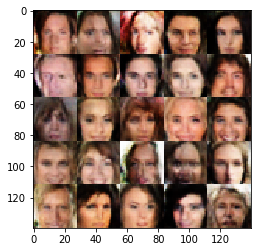

Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6726
Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6949


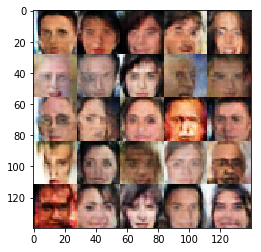

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7029
Epoch 1/1... Discriminator Loss: 1.5081... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7865
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7462


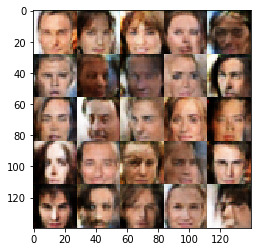

Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.4920... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4599... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8166


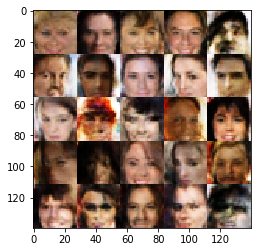

Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7182
Epoch 1/1... Discriminator Loss: 1.4060... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3996... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.8297


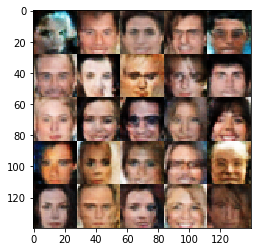

Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.8394


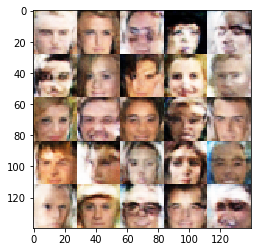

Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.8553
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.6526


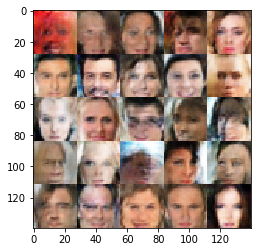

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7617


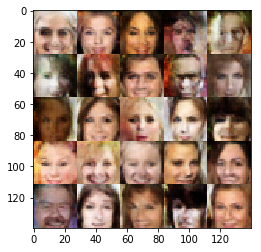

Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6570
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.7555


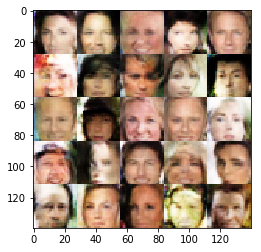

Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.7596


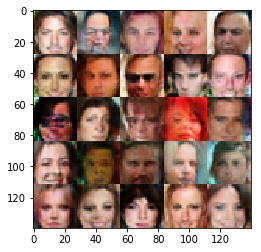

Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.8881
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 0.6996


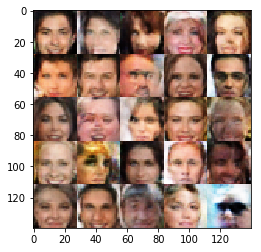

Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7113


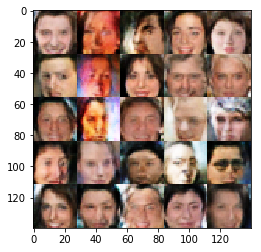

Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.6464
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.7166


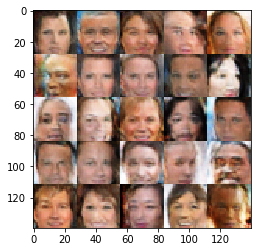

Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6956


In [23]:
batch_size = 64
z_dim = 100
learning_rate = 0.00015
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

## Some results
### DGDGG
###### learning_rate = 0.0002

**MNIST:**
```
Epoch 2/2... Discriminator Loss: 1.0791... Generator Loss: 1.3100
Epoch 2/2... Discriminator Loss: 0.9324... Generator Loss: 1.3398
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 1.4586
```
**CELEB:**
```
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.6947
```

######  learning_rate = 0.0001

**MNIST:**
```
Epoch 2/2... Discriminator Loss: 1.1008... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 0.9857... Generator Loss: 1.2152
Epoch 2/2... Discriminator Loss: 1.0183... Generator Loss: 1.4090

Epoch 2/2... Discriminator Loss: 1.0609... Generator Loss: 1.2262
Epoch 2/2... Discriminator Loss: 0.9391... Generator Loss: 1.3482
Epoch 2/2... Discriminator Loss: 0.9747... Generator Loss: 1.5003
```

######  learning_rate = 0.00015
** MNIST:**
```
Epoch 2/2... Discriminator Loss: 1.1489... Generator Loss: 1.1117
Epoch 2/2... Discriminator Loss: 1.0890... Generator Loss: 1.2343
Epoch 2/2... Discriminator Loss: 0.9280... Generator Loss: 1.2623
```
**CELEB:**
```
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.6956
```

###  DG -> lower performance
######  learning_rate = 0.0001
** MNIST:**
```
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 0.7312
Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 2.4651
Epoch 2/2... Discriminator Loss: 0.8163... Generator Loss: 1.6316
```


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.